<a href="https://colab.research.google.com/github/y-oth/dst_assessment2/blob/main/Elliot%20M/IntegratedGradientsImplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


TO DO THIS, GO ON KAGGLE :https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri

THEN DOWLOAD TO ZIP USINNG THE DOWLOAD BUTTON.

THEN ADD IT TO YOUR GOOGLE DRIVE AS A ZIP FILE.
THEN MYDIRVE/YOUR_NOTEBOOK/DATASET.ZIP


In [2]:
!unzip -q "/content/drive/MyDrive/DST/archive.zip" -d "/content/data"



In [3]:
!ls /content/data


Testing  Training


Loaded image: /content/data/Training/meningioma_tumor/m3 (134).jpg


(np.float64(-0.5), np.float64(305.5), np.float64(364.5), np.float64(-0.5))

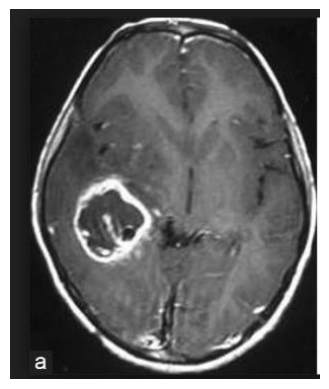

In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt

root = "/content/data/Training"

# Find the first image in the training folder
image_path = None
for subdir, dirs, files in os.walk(root):
    for file in files:
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            image_path = os.path.join(subdir, file)
            break
    if image_path:
        break

print("Loaded image:", image_path)

img = Image.open(image_path)
plt.imshow(img)
plt.axis("off")


## Simple CNN Model

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SmallCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)

        # 224 → 112 → 56 after pooling twice
        self.fc1 = nn.Linear(32 * 56 * 56, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # (16, 112, 112)
        x = self.pool(F.relu(self.conv2(x)))   # (32, 56, 56)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


## Multi-Layer Perceptron:

Here, we also build a simple multi-layer perceptron which will likely perform badly, and using our interpretation method heatmaps, we can show that the MLP does not encapture the 2D structure of the input (image) and therefore performs much worse.

In [6]:
class BrainTumourMLP(nn.Module):
    def __init__(self, input_dim=3*224*224, hidden1=512, hidden2=256, num_classes=4):
        super().__init__()

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(hidden2, num_classes)
        )

    def forward(self, x):
        return self.model(x)


## Dataloaders

These will stay the same for the CNN and MLP as the MLP flattens the image as the first step using nn.Flatten().

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

train_dataset = datasets.ImageFolder("/content/data/Training", transform=transform)
test_dataset  = datasets.ImageFolder("/content/data/Testing",  transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


## CNN Training block

In [8]:
import torch.optim as optim
import os, time, json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallCNN(num_classes=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

best_val_acc = 0
checkpoint_path = "best_smallcnn.pth"

history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

EPOCHS = 10   # fast training

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total


    model.eval()
    val_running_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / len(test_loader)
    val_acc = val_correct / val_total

    # Track
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] | "
          f"Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}")

    # Save based on accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Saved best model → {checkpoint_path}")


Epoch [1/10] | Train Acc: 0.640 | Val Acc: 0.500
Saved best model → best_smallcnn.pth
Epoch [2/10] | Train Acc: 0.844 | Val Acc: 0.624
Saved best model → best_smallcnn.pth
Epoch [3/10] | Train Acc: 0.927 | Val Acc: 0.688
Saved best model → best_smallcnn.pth
Epoch [4/10] | Train Acc: 0.967 | Val Acc: 0.711
Saved best model → best_smallcnn.pth
Epoch [5/10] | Train Acc: 0.989 | Val Acc: 0.728
Saved best model → best_smallcnn.pth
Epoch [6/10] | Train Acc: 0.994 | Val Acc: 0.739
Saved best model → best_smallcnn.pth
Epoch [7/10] | Train Acc: 0.992 | Val Acc: 0.706
Epoch [8/10] | Train Acc: 0.985 | Val Acc: 0.693
Epoch [9/10] | Train Acc: 0.999 | Val Acc: 0.726
Epoch [10/10] | Train Acc: 1.000 | Val Acc: 0.731


In [9]:
model = SmallCNN(num_classes=4)
model.load_state_dict(torch.load("best_smallcnn.pth"))
model.to(device)
model.eval()


SmallCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)

## MLP Training Block

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp = BrainTumourMLP(num_classes=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

def compute_accuracy(model, data_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

for epoch in range(10):
    mlp.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = mlp(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_acc = compute_accuracy(mlp, train_loader, device)
    test_acc = compute_accuracy(mlp, test_loader, device)

    print(
        f"Epoch {epoch+1:02d} | "
        f"Loss: {running_loss/len(train_loader):.4f} | "
        f"Train Acc: {train_acc*100:.2f}% | "
        f"Test Acc: {test_acc*100:.2f}%"
    )


Epoch 01 | Loss: 9.1749 | Train Acc: 59.30% | Test Acc: 36.80%
Epoch 02 | Loss: 1.3308 | Train Acc: 65.23% | Test Acc: 43.15%
Epoch 03 | Loss: 1.1247 | Train Acc: 47.28% | Test Acc: 39.34%
Epoch 04 | Loss: 1.3106 | Train Acc: 34.43% | Test Acc: 38.32%
Epoch 05 | Loss: 1.3857 | Train Acc: 59.30% | Test Acc: 41.37%
Epoch 06 | Loss: 1.1785 | Train Acc: 61.78% | Test Acc: 45.43%
Epoch 07 | Loss: 1.0840 | Train Acc: 68.33% | Test Acc: 50.00%
Epoch 08 | Loss: 1.0326 | Train Acc: 67.00% | Test Acc: 41.12%
Epoch 09 | Loss: 1.0163 | Train Acc: 66.06% | Test Acc: 49.49%
Epoch 10 | Loss: 1.0009 | Train Acc: 66.59% | Test Acc: 49.49%


In [11]:
mlp.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = mlp(images)
        _, predicted = outputs.max(1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"MLP Test Accuracy: {correct/total:.4f}")


MLP Test Accuracy: 0.4949


As we would expect, the MLP gets a low test accuracy. Now we will implement our interpretation methods and show that the CNN highlights meaning regions (tumour outlines) and the MLP does not.

## Integrated Gradients Implementation

In [12]:

def integrated_gradients(model, x, baseline=None, m_steps=50):
    """
    Compute Integrated Gradients for an input x.
    model: pytorch model
    x: input image tensor of shape (1, C, H, W)
    baseline: same shape as x
    m_steps: number of steps in the Riemann approximation
    """

    model.eval()
    if baseline is None:
        baseline = torch.zeros_like(x)

    # interpolate between baseline and x
    alphas = torch.linspace(0, 1, m_steps).reshape(-1, 1, 1, 1).to(x.device)
    interpolated = baseline + alphas * (x - baseline)

    # store gradients
    gradients = []

    for i in range(m_steps):
        interpolated_i = interpolated[i].unsqueeze(0).requires_grad_(True)
        output = model(interpolated_i)
        target = output.max(1)[0]  # predicted class score

        model.zero_grad()
        target.backward()

        gradients.append(interpolated_i.grad.detach())

    # approximate integral
    avg_gradients = torch.mean(torch.stack(gradients), dim=0)

    # IG formula
    ig = (x - baseline) * avg_gradients
    return ig


## SG-IG Implementation

In [13]:

def smooth_integrated_gradients(
    model, x, baseline=None, m_steps=50, n_samples=25, noise_sigma=0.1
):
    """
    Compute Smooth Integrated Gradients.
    Averaging IG over noise-perturbed copies of input x.
    """

    model.eval()
    if baseline is None:
        baseline = torch.zeros_like(x)

    all_igs = []

    for _ in range(n_samples):
        noise = torch.normal(mean=0, std=noise_sigma, size=x.shape).to(x.device)
        x_noisy = x + noise
        ig = integrated_gradients(model, x_noisy, baseline, m_steps)
        all_igs.append(ig)

    return torch.mean(torch.stack(all_igs), dim=0)


## Heatmap plots

Let's get some explainer images and then apply the two interpretation methods, for both the CNN and MLP. First we need to denormalize the explainer images in order to get meaningful plots. Then we can plot heatmaps for each image.

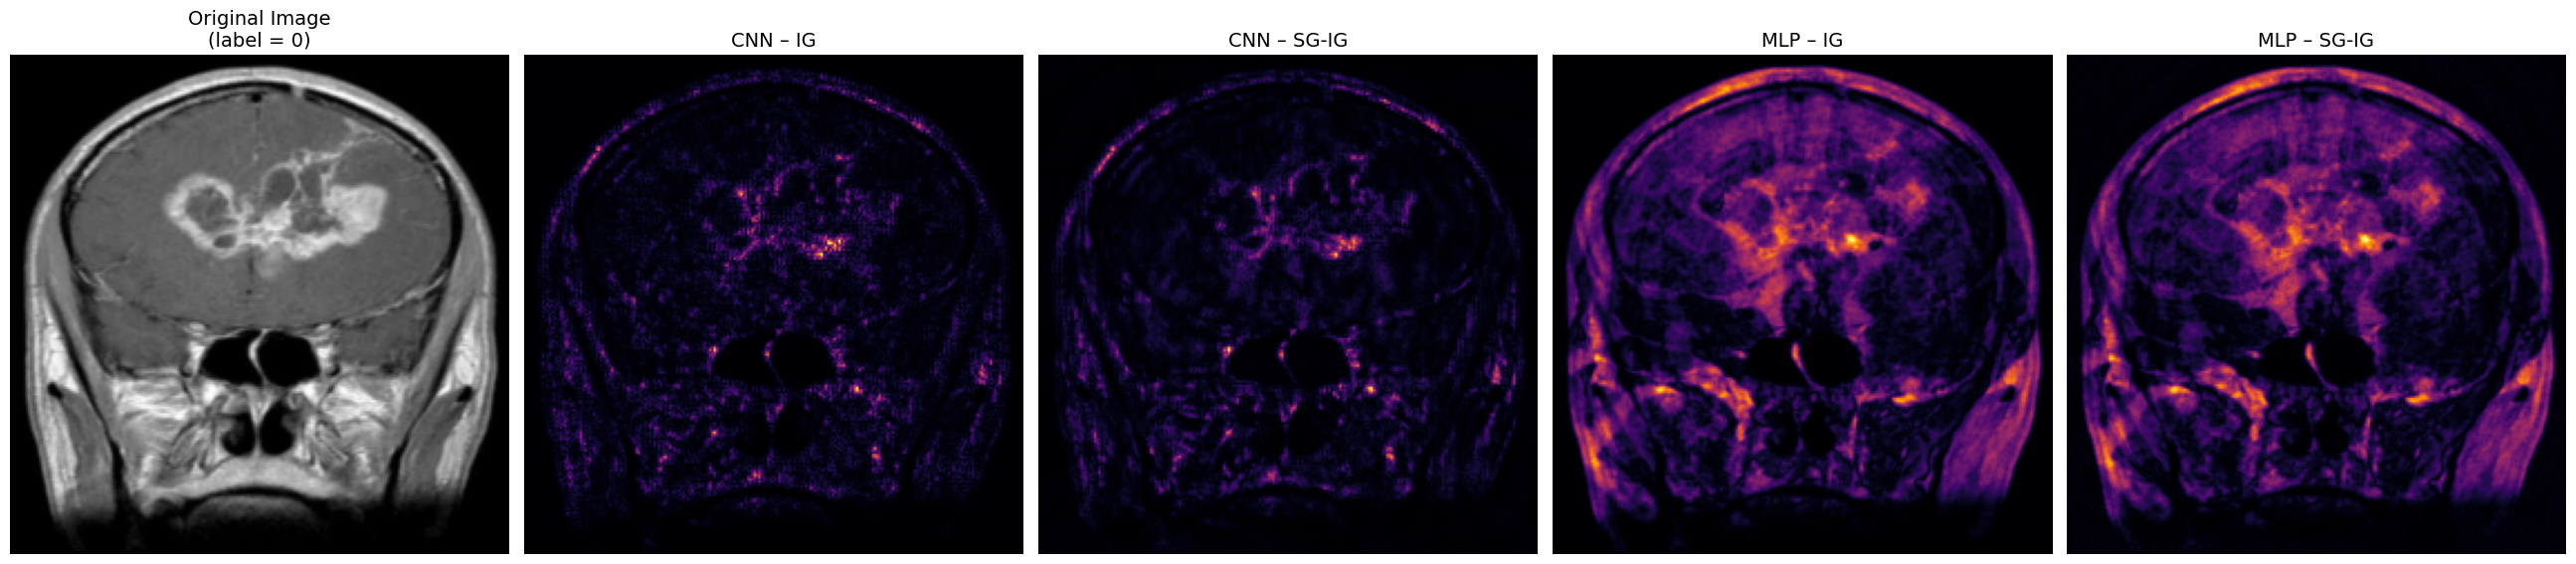

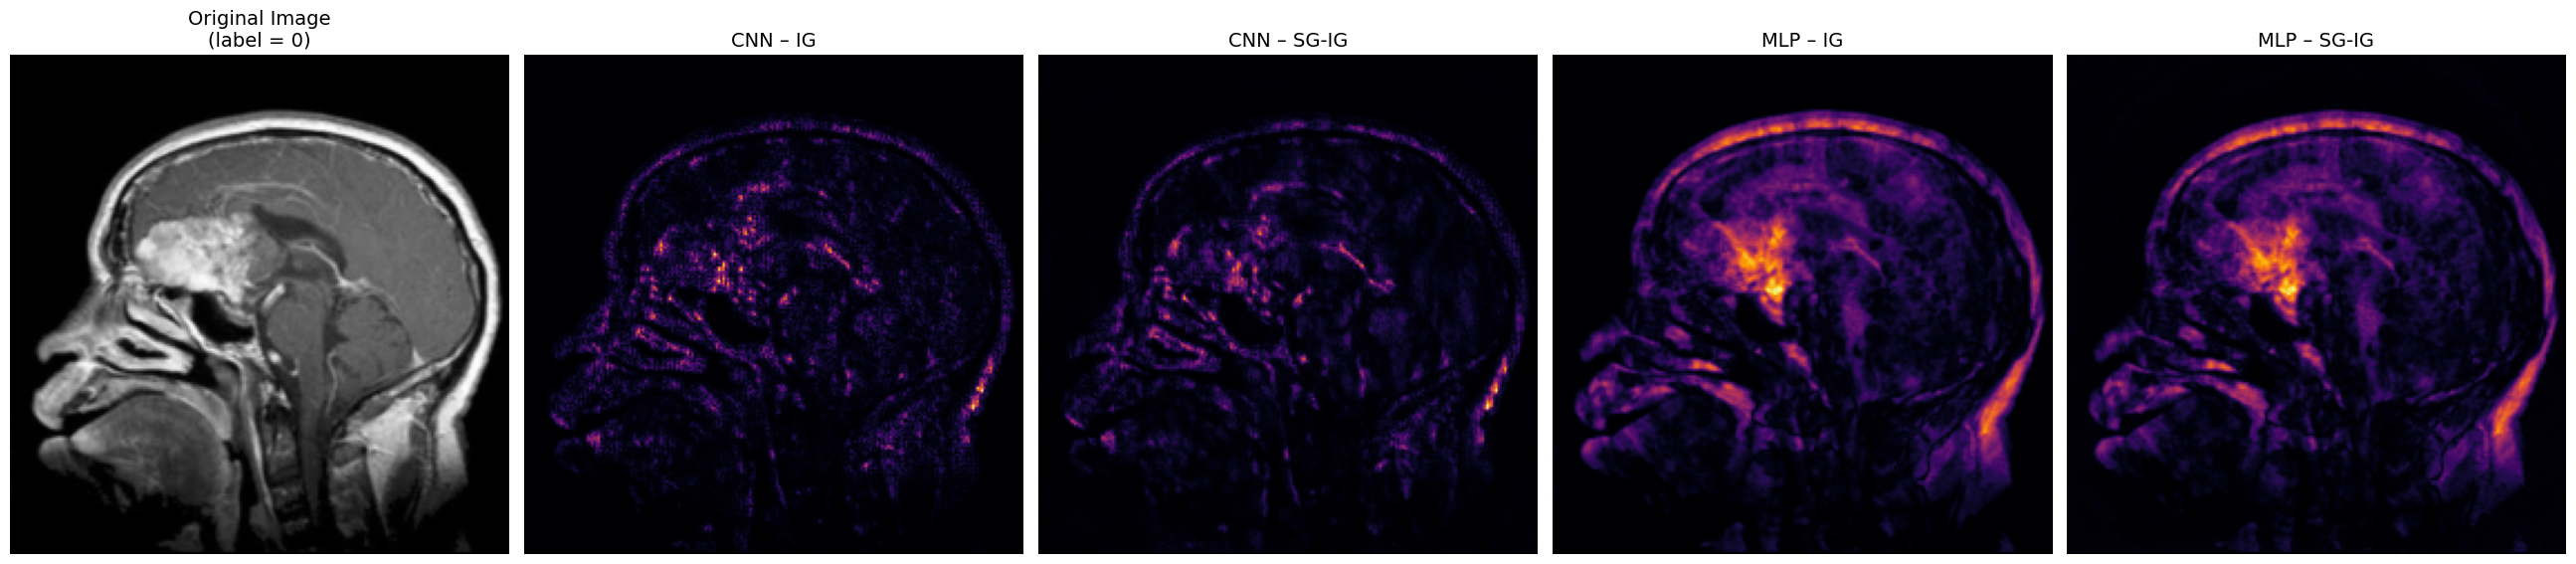

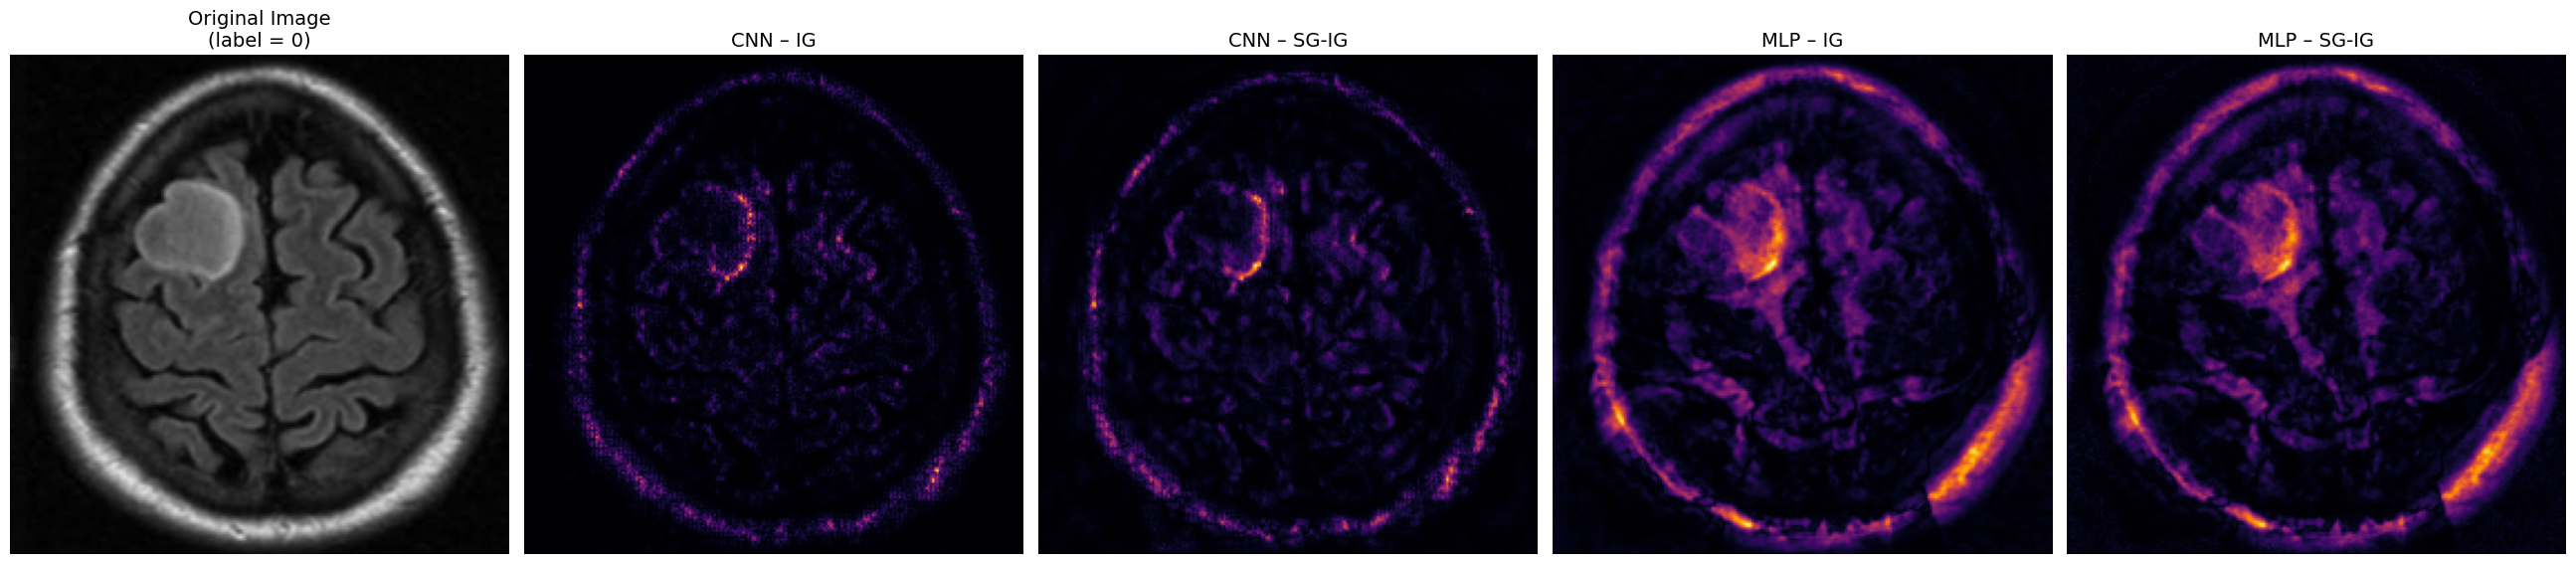

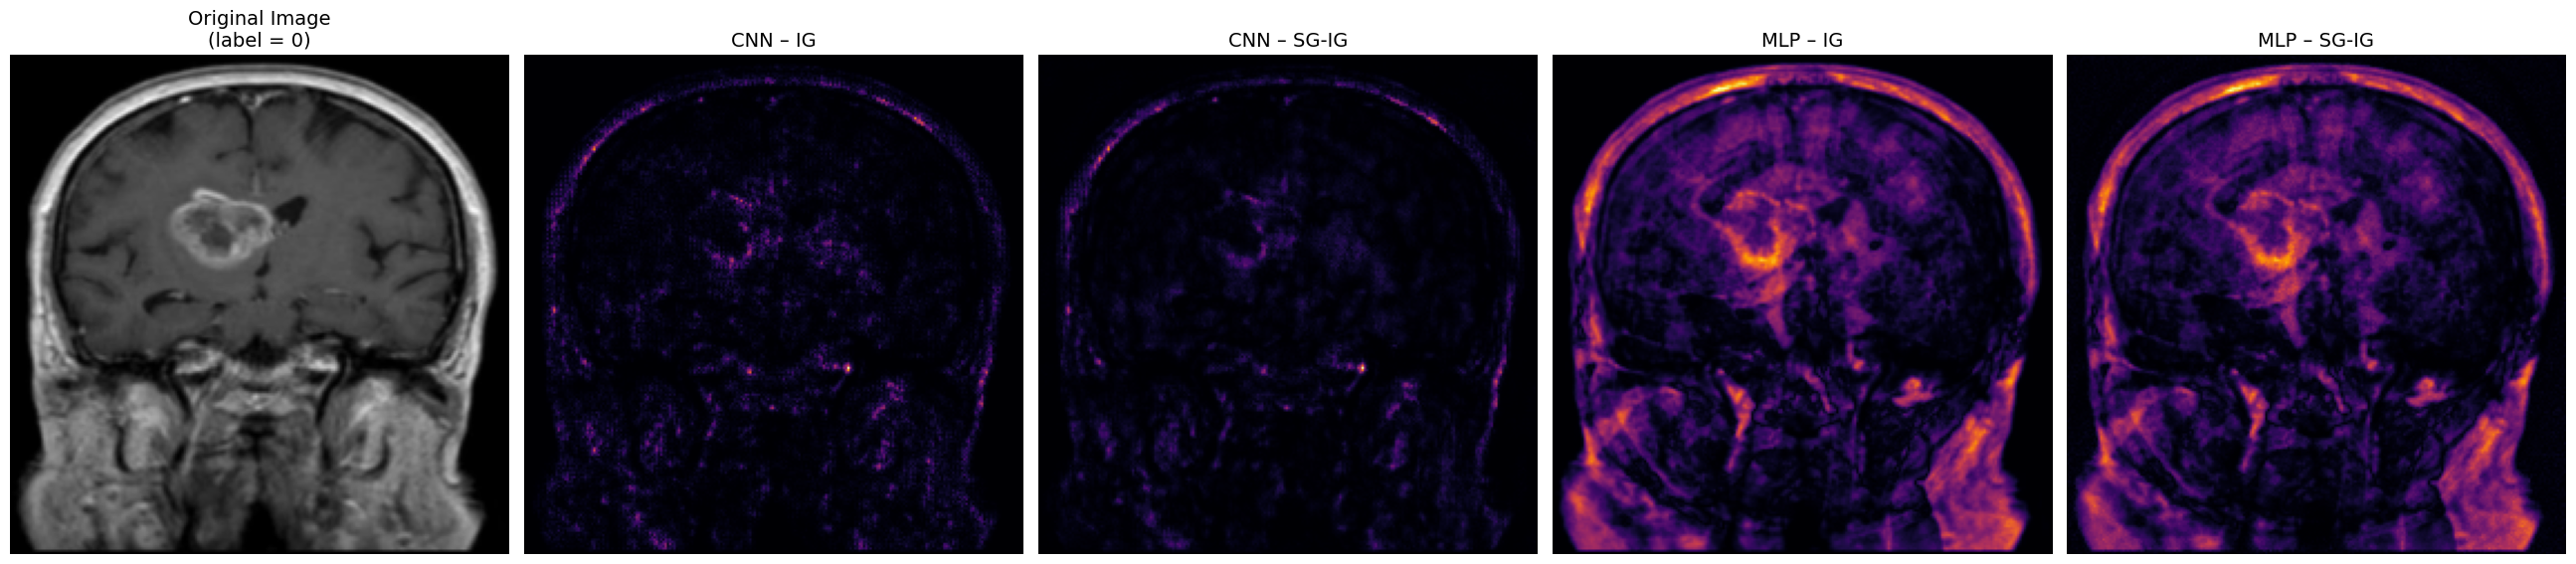

In [15]:
import numpy as np
explainer_images, explainer_labels = next(iter(test_loader))

batch_size = explainer_images.shape[0]

# batch size is 32 so I am going to do the first 4
for i in range(batch_size//8):

    explainer_image = explainer_images[i]
    explainer_label = explainer_labels[i].item()

    explainer_image_device = explainer_image.unsqueeze(0).to(device)

    def denormalize(x, mean, std):
        mean = torch.tensor(mean).view(1, 3, 1, 1).to(x.device)
        std = torch.tensor(std).view(1, 3, 1, 1).to(x.device)
        return x * std + mean


    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    explainer_image_denorm = denormalize(explainer_image_device, mean, std)
    baseline = torch.zeros_like(explainer_image_denorm)

    # CNN
    cnn_ig = integrated_gradients(
        model=model,
        x=explainer_image_denorm,
        baseline=baseline,
        m_steps=50
    )

    cnn_sg_ig = smooth_integrated_gradients(
        model=model,
        x=explainer_image_denorm,
        baseline=baseline,
        m_steps=50,
        n_samples=20,
        noise_sigma=0.1
    )

    # MLP

    mlp_ig = integrated_gradients(
        model=mlp,
        x=explainer_image_denorm,
        baseline=baseline,
        m_steps=50
    )

    mlp_sg_ig = smooth_integrated_gradients(
        model=mlp,
        x=explainer_image_denorm,
        baseline=baseline,
        m_steps=50,
        n_samples=20,
        noise_sigma=0.1
    )



    def to_heatmap(attr):
        # attr: shape (1, 3, H, W)
        attr = attr.squeeze(0).detach().cpu().numpy()   # (3, H, W)
        return np.abs(attr).mean(axis=0)                # (H, W)

    def to_numpy_image(t):
        """Convert (1,3,H,W) or (3,H,W) tensor to (H,W,3) NumPy for plotting."""
        t = t.detach().cpu()
        if t.ndim == 4:  # (1,C,H,W)
            t = t.squeeze(0)
        t = t.permute(1, 2, 0)   # C,H,W → H,W,C
        return t.numpy()

    # ORIGINAL IMAGE (DENORMALIZED)

    orig_np = to_numpy_image(explainer_image_denorm)
    orig_np = np.clip(orig_np, 0, 1)   # ensure valid RGB range


    # HEATMAPS

    heatmaps = [
        ("CNN – IG", to_heatmap(cnn_ig)),
        ("CNN – SG-IG", to_heatmap(cnn_sg_ig)),
        ("MLP – IG", to_heatmap(mlp_ig)),
        ("MLP – SG-IG", to_heatmap(mlp_sg_ig)),
    ]

    # PLOT ALL TOGETHER
    fig, axes = plt.subplots(1, 1 + len(heatmaps), figsize=(26, 6))

    # Original Image
    axes[0].imshow(orig_np)
    axes[0].set_title(f"Original Image\n(label = {explainer_label})", fontsize=14)
    axes[0].axis("off")

    # Heatmaps
    for ax, (title, hm) in zip(axes[1:], heatmaps):
        ax.imshow(hm, cmap="inferno")
        ax.set_title(title, fontsize=14)
        ax.axis("off")

    plt.tight_layout()
    plt.show()



These are interesting results. For some of the plots, suprisingly, the MLP seems to highlight the tumour much more accurately and strongly than the CNN. However, on some of the other plots, as we would expect, the MLP just seems to highlight everything, and not the tumour any more than anything else. The CNN for some plots does seem to hone in much more on the tumour, and doesn't highlight other irrelevant parts like the skull as much. The CNN we fitted was a simpler version of the full model, so in the report section we will hopefully find that our final model produces more accurate heatmaps around the tumour. Nonetheless, it is clear to see these interpretation methods are working for our models / data.

## MoRF Implementation

Here we implement MoRF for both Integrated Gradients and SG-IG. Both the peturb_topk_regions() and compute_aopc_morf() functions I have taken from Youssef. This method of quantitative comparison is motivated in the report section of the GitHub.

In [19]:
def perturb_topk_regions(
    image: torch.Tensor,
    saliency: torch.Tensor,
    k: int,
    patch_size: int = 16,
    perturbation: str = "zero"
):
    """
    Perturbs the k-most relevant regions in the image based on a saliency map.

    Args:
        image (Tensor): Input image of shape (1, C, H, W).
        saliency (Tensor): Saliency map of shape (1, 1, H, W) or (H, W).
        k (int): Number of most relevant patches to perturb.
        patch_size (int): Side length of square patches.
        perturbation (str): One of ["zero", "mean"].

    Returns:
        perturbed_image (Tensor): Image after perturbation.
        deletion_mask (Tensor): Binary mask (1 = perturbed region).
        perturbed_indices (list): List of flattened patch indices.
    """

# Normalise and reshape input

    if saliency.dim() == 4:
        sal = saliency[0, 0]
    elif saliency.dim() == 3:
        sal = saliency[0]
    else:
        sal = saliency

    C, H, W = image.shape[-3:]


# Break saliency map into patches

    # number of patches along each dimension
    n_h = H // patch_size
    n_w = W // patch_size
    total_patches = n_h * n_w

    # reshape saliency into (n_h, n_w) grid of patch scores
    sal_reshaped = F.avg_pool2d(
        sal.unsqueeze(0).unsqueeze(0),
        kernel_size=patch_size,
        stride=patch_size
    ).reshape(n_h, n_w)

    # Flatten to sort by relevance
    patch_scores = sal_reshaped.flatten()            # shape (n_h*n_w)
    topk_indices = torch.topk(patch_scores, k).indices.tolist()

    #  Build deletion mask for visualisation

    deletion_mask = torch.zeros((H, W), dtype=torch.float32)

    for idx in topk_indices:
        row = idx // n_w
        col = idx % n_w

        h_start = row * patch_size
        w_start = col * patch_size

        deletion_mask[h_start:h_start+patch_size,
                      w_start:w_start+patch_size] = 1.0

    # Apply perturbation to image

    perturbed_image = image.clone()

    for idx in topk_indices:
        row = idx // n_w
        col = idx % n_w

        h_start = row * patch_size
        w_start = col * patch_size

        if perturbation == "zero":
            perturbed_image[..., h_start:h_start+patch_size,
                             w_start:w_start+patch_size] = 0.0

        elif perturbation == "mean":
            mean_val = image.mean()
            perturbed_image[..., h_start:h_start+patch_size,
                             w_start:w_start+patch_size] = mean_val

        else:
            raise ValueError("Unknown perturbation strategy")

    # reshape mask to match image dims
    deletion_mask = deletion_mask.unsqueeze(0)

    return perturbed_image, deletion_mask, topk_indices

In [20]:
def compute_aopc_morf(
    model,
    image,
    saliency,
    max_k,
    patch_size=16,
    perturbation="zero",
    target_class=None,
    device="cpu",
):
    """
    Computes AOPC-MoRF (Most Relevant First) score for a single image and a single saliency map.
    """

    model.eval()

    #Ensure image has batch dim
    if image.dim() == 3:
        image = image.unsqueeze(0)

    image = image.to(device)

    #Handle numpy saliency
    if isinstance(saliency, np.ndarray):
        saliency = torch.from_numpy(saliency).float()

    saliency = saliency.to(device)

    #Get f(x)
    with torch.no_grad():
        logits = model(image)
        if target_class is None:
            target_class = logits.argmax(dim=1).item()
        original_score = F.softmax(logits, dim=1)[0, target_class].item()

    scores = [original_score]

    # Normalise saliency shape
    if saliency.dim() == 4:
        sal = saliency[0, 0]
    else:
        sal = saliency.squeeze()

    C, H, W = image.shape[-3:]

    # Patch grid
    n_h = H // patch_size
    n_w = W // patch_size

    # Average patch saliency
    sal_pooled = F.avg_pool2d(
        sal.unsqueeze(0).unsqueeze(0),
        kernel_size=patch_size,
        stride=patch_size
    ).reshape(n_h * n_w)

    sorted_indices = torch.argsort(sal_pooled, descending=True)

    # Perturb cumulatively
    current_img = image.clone()

    for k in range(1, max_k + 1):

        if current_img.dim() == 3:
            current_img = current_img.unsqueeze(0)

        idx = sorted_indices[k - 1].item()
        row = idx // n_w
        col = idx % n_w

        h_start = row * patch_size
        w_start = col * patch_size

        if perturbation == "zero":
            current_img[:, :, h_start:h_start+patch_size,
                            w_start:w_start+patch_size] = 0.0

        elif perturbation == "mean":
            mean_val = image.mean()
            current_img[:, :, h_start:h_start+patch_size,
                            w_start:w_start+patch_size] = mean_val

        # Compute f(x_k)
        with torch.no_grad():
            logit_k = model(current_img)
            score_k = F.softmax(logit_k, dim=1)[0, target_class].item()

        scores.append(score_k)

    # Compute AOPC-MoRF
    scores = torch.tensor(scores)
    deltas = original_score - scores[1:]
    aopc_score = deltas.mean().item()

    return aopc_score, scores.tolist()

In [23]:

# Prepare a test image
images, labels = next(iter(test_loader))

img = images[0].unsqueeze(0).to(device)   # [1,3,224,224]
target_class = labels[0].item()


baseline = torch.zeros_like(img)

# saliency map for IG
ig_map = integrated_gradients(
        model=model,
        x=img,
        baseline=baseline,
        m_steps=50
    )

# saliency map for SG-IG
sg_ig_map = smooth_integrated_gradients(
        model=model,
        x=img,
        baseline=baseline,
        m_steps=50,
        n_samples=20,
        noise_sigma=0.1
    )

# MoRF for IG
aopc_ig, curve_ig = compute_aopc_morf(
    model=model,
    image=img,
    saliency=ig_map,
    max_k=20,
    patch_size=16,
    perturbation="zero",
    device=device
)

# MoRF for SG-IG
aopc_sg, curve_sg = compute_aopc_morf(
    model=model,
    image=img,
    saliency=sg_ig_map,
    max_k=20,
    patch_size=16,
    perturbation="zero",
    device=device
)

print("AOPC IG:", aopc_ig)
print("AOPC SG-IG:", aopc_sg)

AOPC IG: 0.8248909711837769
AOPC SG-IG: 0.8432379961013794


# AOPC-MoRF plots (for sinular image)


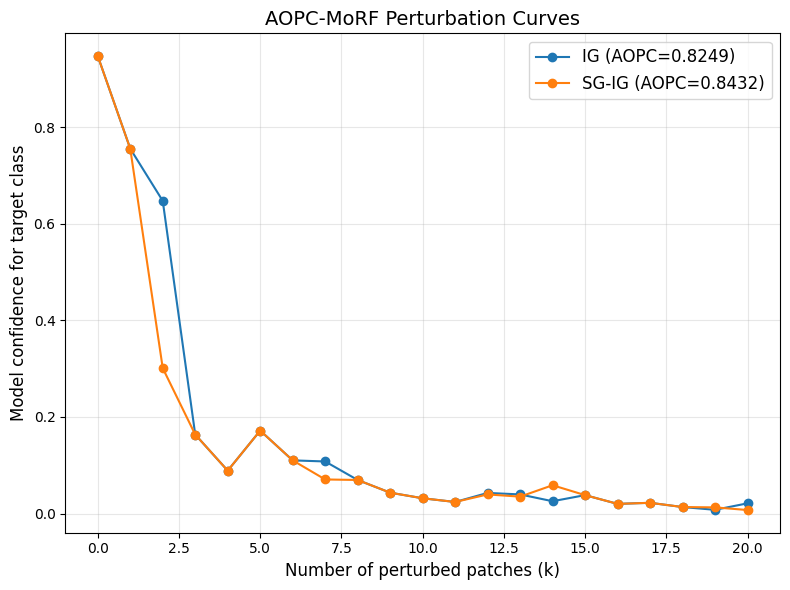

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

k_values = list(range(len(curve_ig)))

plt.plot(k_values, curve_ig, marker='o', label=f"IG (AOPC={aopc_ig:.4f})")
plt.plot(k_values, curve_sg, marker='o', label=f"SG-IG (AOPC={aopc_sg:.4f})")

plt.xlabel("Number of perturbed patches (k)", fontsize=12)
plt.ylabel("Model confidence for target class", fontsize=12)
plt.title("AOPC-MoRF Perturbation Curves", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


# AOPC MoRF for a batch of images

In [28]:
def batch_aopc_scores(
    model,
    images,
    ig_fn,
    sg_ig_fn,
    max_k=20,
    patch_size=16,
    device="cuda"
):
    """
    Computes AOPC-MoRF for each image in a batch for:
        - Integrated Gradients (IG)
        - SmoothGrad-IG (SG-IG)

    Returns:
        avg_aopc_ig, avg_aopc_sg
        aopc_list_ig, aopc_list_sg
        avg_curve_ig, avg_curve_sg
    """

    model.eval()
    images = images.to(device)

    batch_size = images.shape[0]

    aopc_list_ig = []
    aopc_list_sg = []
    curves_ig = []
    curves_sg = []

    baseline = torch.zeros_like(images[0]).unsqueeze(0)

    for i in range(batch_size):
        img = images[i].unsqueeze(0).to(device)

        # IG saliency mao
        ig_map = ig_fn(
            model=model,
            x=img,
            baseline=baseline,
            m_steps=50
        )

        aopc_ig, curve_ig = compute_aopc_morf(
            model=model,
            image=img,
            saliency=ig_map,
            max_k=max_k,
            patch_size=patch_size,
            device=device
        )

        aopc_list_ig.append(aopc_ig)
        curves_ig.append(curve_ig)

        # SG-IG saliency map
        sg_map = sg_ig_fn(
        model=model,
        x=img,
        baseline=baseline,
        m_steps=50,
        n_samples=20,
        noise_sigma=0.1
    )

        aopc_sg, curve_sg = compute_aopc_morf(
            model=model,
            image=img,
            saliency=sg_map,
            max_k=max_k,
            patch_size=patch_size,
            device=device
        )

        aopc_list_sg.append(aopc_sg)
        curves_sg.append(curve_sg)

    # Convert to tensors for easier averaging
    curves_ig = torch.tensor(curves_ig)
    curves_sg = torch.tensor(curves_sg)

    avg_curve_ig = curves_ig.mean(dim=0).tolist()
    avg_curve_sg = curves_sg.mean(dim=0).tolist()

    avg_aopc_ig = sum(aopc_list_ig) / batch_size
    avg_aopc_sg = sum(aopc_list_sg) / batch_size

    return (
        avg_aopc_ig, avg_aopc_sg,
        aopc_list_ig, aopc_list_sg,
        avg_curve_ig, avg_curve_sg
    )


In [29]:
images, labels = next(iter(test_loader))

(
    avg_aopc_ig,
    avg_aopc_sg,
    aopc_list_ig,
    aopc_list_sg,
    avg_curve_ig,
    avg_curve_sg
) = batch_aopc_scores(
    model=model,
    images=images,
    ig_fn=integrated_gradients,
    sg_ig_fn=smooth_integrated_gradients,
    max_k=20,
    patch_size=16,
    device=device
)

print("Average AOPC IG:", avg_aopc_ig)
print("Average AOPC SG-IG:", avg_aopc_sg)
print("Individual IG scores:", aopc_list_ig)
print("Individual SG-IG scores:", aopc_list_sg)


Average AOPC IG: 0.34120974999950704
Average AOPC SG-IG: 0.3510390949759312
Individual IG scores: [0.8248909711837769, 0.5321851968765259, 0.5482900738716125, 0.5055438876152039, 0.5055438876152039, 0.045838505029678345, -0.21940210461616516, 0.17999866604804993, 0.20283767580986023, 0.3611055612564087, 0.021097343415021896, 0.3815682828426361, 0.010243442840874195, 0.0002558022679295391, 0.8647034764289856, 0.16196870803833008, 0.007398039102554321, 0.7708081007003784, 0.5682022571563721, 0.10725462436676025, 0.5350047945976257, 0.15087036788463593, 0.15087036788463593, 0.03039272129535675, 0.25340551137924194, 0.642105758190155, 0.3455027937889099, 0.870265781879425, 0.5302404165267944, 0.2584516406059265, 0.7332463264465332, 0.038023121654987335]
Individual SG-IG scores: [0.8436018824577332, 0.5146624445915222, 0.5586122870445251, 0.5887553095817566, 0.5950456857681274, 0.04359552636742592, -0.11290428787469864, 0.1563771665096283, 0.13415679335594177, 0.36580246686935425, 0.0246570

# Plot Average Pertubation Curves

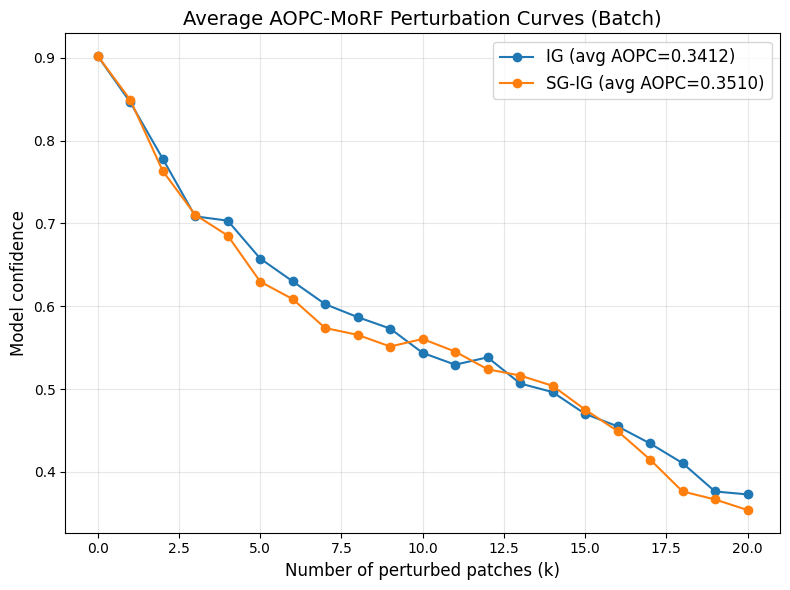

In [30]:
plt.figure(figsize=(8, 6))

k_values = list(range(len(avg_curve_ig)))

plt.plot(k_values, avg_curve_ig, marker='o', label=f"IG (avg AOPC={avg_aopc_ig:.4f})")
plt.plot(k_values, avg_curve_sg, marker='o', label=f"SG-IG (avg AOPC={avg_aopc_sg:.4f})")

plt.xlabel("Number of perturbed patches (k)", fontsize=12)
plt.ylabel("Model confidence", fontsize=12)
plt.title("Average AOPC-MoRF Perturbation Curves (Batch)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


This plot shows us how quickly the model's confidence drops as we sequentially erase the most salient regions. Therefore, since SG-IG has a steeper curve, and has the higher AOPC, we would conclude from this analysis that for the simple CNN, and for the brain tumour classification data, the better interpretation method is SG-IG. The SG-IG method reduced the noise in IG maps, which has worked effectively in this context. That being said, the improvement over regular IG is not large, and IG is definitely still a useful tool in this context, and is computationally cheaper. For a full comparison of all the different models, and for a more complex CNN model, see the report section.